In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from utils.model_datatransforms import *

In [3]:
df = pd.read_parquet('pred_model_data_full.parquet')

In [5]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [6]:
categories_to_drop = ['Music non-amplified', 'Nature elements - Wind', 'Unsupported']
df = df[~df['noise_event_laeq_primary_detected_class'].isin(categories_to_drop)]

In [7]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [8]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('randomForest', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=250, min_samples_split=8, max_depth=9, ccp_alpha=1e-05))
])

In [73]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.7384799013385223

In [75]:
n_estimators = np.arange(150, 300, 50) # number of trees in the random forest
max_depth = np.arange(9,12) # maximum number of levels allowed in each decision tree
min_samples_split = np.arange(8,11) # minimum sample number to split a node
ccp_alpha = np.array([1e-7, 1e-6, 1e-5])

random_grid = {
    'month_handler__strategy': ['month'], #'season'
    'day_of_the_week_handler__strategy': ['full'], #'weekend'
    'randomForest__n_estimators': n_estimators,
    'randomForest__max_depth': max_depth,
    'randomForest__min_samples_split': min_samples_split,
    'randomForest__ccp_alpha': ccp_alpha   
}

In [76]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=600, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
#print("Best Estimator:", search.best_estimator_)
print("Best Parameters:", search.best_params_)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 81 is smaller than n_iter=600. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.7477083545580653
Best Parameters: {'randomForest__n_estimators': 250, 'randomForest__min_samples_split': 8, 'randomForest__max_depth': 9, 'randomForest__ccp_alpha': 1e-05, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full'}


In [7]:
search.cv_results_

{'mean_fit_time': array([11.13800486, 18.20289103, 14.42500679, 14.02895141, 14.2068247 ,
         9.91615939,  8.64719168,  9.71210003, 16.38163106, 15.44246586,
        12.45641907, 11.08945036, 12.21381299,  9.78738149, 15.87462815,
        11.94766068, 15.25838017, 19.19469492,  9.26591682, 18.18337488,
        16.89109556, 10.92034888, 16.48265266, 11.5814627 , 10.64943027,
        11.91273276, 18.24418577,  9.05676444, 12.13209732, 10.7321678 ,
         8.99068268, 12.00829148, 11.50263238, 11.79011758, 10.70698055,
         5.87215527, 12.93064316,  7.727789  ,  7.6554424 ,  8.97417585,
         9.22327733,  7.19600821,  8.23659905,  6.19696434,  7.19047864,
         8.22382331, 13.54688509,  6.74758498, 13.16751361,  6.50276121,
        12.98260291, 10.2716194 ,  9.94304268, 10.39840738, 10.91501721,
        10.33765014,  6.25708985, 12.05869087, 13.24440591,  8.9471155 ,
        13.2487239 , 13.92936365,  8.85119764,  6.79023846, 10.85100325,
        10.35077405,  7.65257279, 

In [78]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_shift_t-_5',
                                         'lceq_shift_t-_5',
        

In [79]:
y_pred = pipeline.predict(X_val)
y_pred

array([1, 2, 0, ..., 0, 2, 2])

In [80]:
y_pred_proba = pipeline.predict_proba(X_val)
y_pred_proba

array([[0.14927567, 0.40014744, 0.34592327, 0.10465362],
       [0.22244887, 0.08353928, 0.57643032, 0.11758152],
       [0.4734808 , 0.03052137, 0.3215754 , 0.17442243],
       ...,
       [0.33043864, 0.19442781, 0.32495292, 0.15018064],
       [0.15954718, 0.10498464, 0.61537054, 0.12009764],
       [0.26078747, 0.16180277, 0.4842166 , 0.09319317]])

In [81]:
balanced_accuracy_score(y_val, y_pred)

0.7688997446948613

In [82]:
roc_auc_score(y_val, y_pred_proba, multi_class='ovo')

0.937198973939235

In [83]:
cm = confusion_matrix(y_val, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

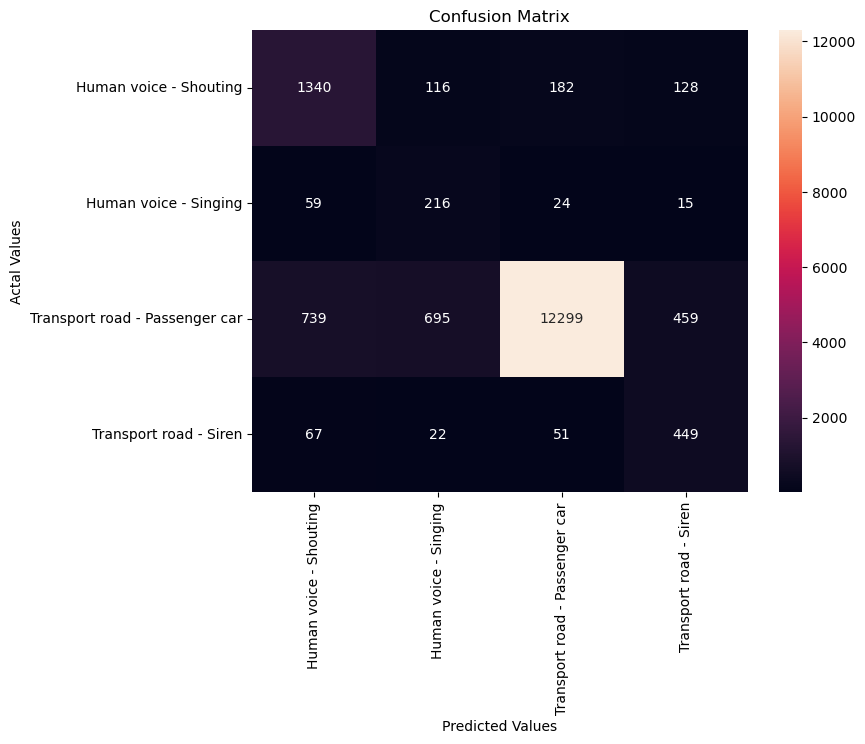

In [84]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')


plt.show()

In [85]:
print(classification_report(y_val, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.61      0.76      0.67      1766
         Human voice - Singing       0.21      0.69      0.32       314
Transport road - Passenger car       0.98      0.87      0.92     14192
        Transport road - Siren       0.43      0.76      0.55       589

                      accuracy                           0.85     16861
                     macro avg       0.56      0.77      0.61     16861
                  weighted avg       0.91      0.85      0.87     16861



Tentativa 1: Best Parameters: {'randomForest__n_estimators': 250, 'randomForest__min_samples_split': 7, 'randomForest__max_depth': 20, 'randomForest__ccp_alpha': 1e-06, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full'} // 0.3673680508822669 // 0.7558049201553734

Tentativa 2: Best Parameters: {'randomForest__n_estimators': 100, 'randomForest__min_samples_split': 5, 'randomForest__max_depth': 6, 'randomForest__ccp_alpha': 1e-07, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full'} // 0.5481787940258478


WITHOUT THE 3 CLASSES:
Best Score: 0.7477083545580653
Best Parameters: {'randomForest__n_estimators': 250, 'randomForest__min_samples_split': 8, 'randomForest__max_depth': 9, 'randomForest__ccp_alpha': 1e-05, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full'}